In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from torch.nn import Softplus #smooth relu
import torch.nn as nn
import torch.nn.functional as F
from utils import generate_polynomial_data
import numpy as np
import torch
import torch.optim as optim
from torch.nn import MSELoss
from tqdm import tqdm

from model import Net, check_loss_landscape

In [28]:
torch.manual_seed(0)

suffix = "3"

n = 20
d = 10000
generate_data = False

coeffs = np.random.rand(d, 1)
xvals = np.random.rand(n)
if generate_data:
    print("Generating Data...")
    X, Y = generate_polynomial_data(coeffs, xvals)
    '''with open("./datasets/X%s.npy" %suffix, "wb") as f:
        np.save(f, X)
    with open("./datasets/Y%s.npy" %suffix, "wb") as f:
        np.save(f, Y)
    with open("./datasets/coeffs%s.npy" %suffix, "wb") as f:
        np.save(f, coeffs)'''
else:
    with open("./datasets/X%s.npy" %suffix, "rb") as f:
        X = np.load(f)
    with open("./datasets/Y%s.npy" %suffix, "rb") as f:
        Y = np.load(f)
    with open("./datasets/coeffs%s.npy" %suffix, "rb") as f:
        coeffs = np.load(f)

In [29]:
net = Net(d, epochs = 20)

In [30]:
device = next(net.parameters()).device

In [31]:
X_cuda = torch.from_numpy(X).to(device)
Y_cuda = torch.from_numpy(Y).to(device)

  0%|          | 1/2000 [00:00<04:18,  7.72it/s]

Epoch 1 iteration 2000 loss: 4009.78


  0%|          | 1/2000 [00:00<04:22,  7.60it/s]

Epoch 2 iteration 2000 loss: 1255.26


  0%|          | 1/2000 [00:00<04:28,  7.44it/s]

Epoch 3 iteration 2000 loss: 1255.26


  0%|          | 1/2000 [00:00<04:20,  7.68it/s]

Epoch 4 iteration 2000 loss: 1255.26


  0%|          | 1/2000 [00:00<04:19,  7.70it/s]

Epoch 5 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 6 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 7 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 8 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 9 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 iteration 2000 loss: 1255.26


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 iteration 2000 loss: 1255.26


100%|██████████| 2000/2000 [07:41<00:00,  4.34it/s]

Epoch 20 iteration 2000 loss: 1255.26


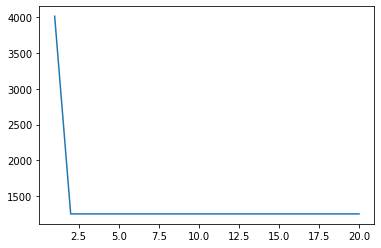

In [32]:
net.train_gd(X, Y, T=2000, lr=1e-03)

In [33]:
model_path = "./models/model_%s.pt"%suffix
torch.save(net.state_dict(), model_path)

[autoreload of model failed: Traceback (most recent call last):
  File "/home/cwang506/.conda/envs/torch-env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/cwang506/.conda/envs/torch-env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/cwang506/.conda/envs/torch-env/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/cwang506/.conda/envs/torch-env/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_w

In [34]:
check_loss_landscape(model_path, X, Y)

Overall loss: tensor(62.7630, grad_fn=<MseLossBackward>)
4.275935173034668 1.395673058120217
4.275935173034668 0.5092175232967956
4.275935173034668 1.0342934638919727
4.275935173034668 2.6966071763222557
4.275935173034668 4.212777224784648
4.275935173034668 0.48522481051099375
4.275935173034668 27.427003793125827
4.275935173034668 1.2415786593346545
4.275935173034668 0.5185361704513592
4.275935173034668 0.7549449502833208
4.275935173034668 0.510679244602981
4.275935173034668 6.364185597174342
4.275935173034668 27.85730795019833
4.275935173034668 0.4873869363326762
4.275935173034668 0.4771608283215414
4.275935173034668 1.5666525496287127
4.275935173034668 2.143945347008627
4.275935173034668 2.7660091615553464
4.275935173034668 0.7902474529950809
4.275935173034668 2.279385803933053
